In [1]:
import os
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import textstat
from collections import Counter

# Load the English language model
nlp = spacy.load("en_core_web_sm")

In [2]:
# This code block gives the comments in a formatted way which lets us convert to a dataframe
def get_comments(filepath):
    comments = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#'):
                comments.append(line)
            else:
                break 
    return comments

def extract_info(comment):
    # Regular expression to extract difficulty, result, and tests from comments
    pattern = r'# (\d+\.\d+) (\w+ [\w\s-]+) (\d+/\d+)'
    match = re.match(pattern, comment)
    if match:
        return match.groups()
    
    pattern_accepted = r'# (\d+\.\d+) (\w+) (\d+/\d+)' 
    match_accepted = re.match(pattern_accepted, comment)
    if match_accepted:
        return match_accepted.groups()
    return None

def find_gpt_files(directory):
    gpt_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'gpt.py':
                gpt_files.append(os.path.join(root, file))
    return gpt_files

def save_comments_to_csv(comments, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Difficulty", "Result", "Tests"])
        for comment in comments:
            info = extract_info(comment)
            if info:
                writer.writerow(info)

def main():
    kattis_dir = os.path.join(os.getcwd(), 'kattis')
    gpt_files = find_gpt_files(kattis_dir)
    all_comments = []

    for filepath in gpt_files:
        comments = get_comments(filepath)
        all_comments.extend(comments)

    if all_comments:
        csv_filename = 'kattis_comments.csv'
        save_comments_to_csv(all_comments, csv_filename)
        print(f"Comments saved to CSV file: {csv_filename}")
    else:
        print("No comments found in any gpt.py files.")

if __name__ == "__main__":
    main()

Comments saved to CSV file: kattis_comments.csv


In [3]:
# Creating a dataframe from the comments csv
df_kattis = pd.read_csv("./kattis_comments.csv")
df_kattis['Result'] = df_kattis['Result'].apply(lambda x: x.lower() if isinstance(x, str) else x)
df_kattis

,Difficulty,Result,Tests
0,3.0,wrong answer,1/19
1,2.7,wrong answer,2/19
2,4.0,wrong answer,0/13
3,2.0,accepted,52/52
4,2.3,wrong answer,0/12
...,...,...,...
150,4.5,wrong answer,0/3
151,5.3,wrong answer,0/47
152,5.4,wrong answer,0/22
153,4.7,runtime error,0/71


In [4]:
# Creating more columns for splitting the tests 
df_kattis[['Correct', 'Total']] = df_kattis['Tests'].str.split('/',expand=True).astype(int)
df_kattis

,Difficulty,Result,Tests,Correct,Total
0,3.0,wrong answer,1/19,1,19
1,2.7,wrong answer,2/19,2,19
2,4.0,wrong answer,0/13,0,13
3,2.0,accepted,52/52,52,52
4,2.3,wrong answer,0/12,0,12
...,...,...,...,...,...
150,4.5,wrong answer,0/3,0,3
151,5.3,wrong answer,0/47,0,47
152,5.4,wrong answer,0/22,0,22
153,4.7,runtime error,0/71,0,71


In [5]:
# Getting the count of each result at the difficulties
grouped = df_kattis.groupby(['Difficulty','Result']).size().unstack(fill_value=0)
grouped

Result,accepted,memory limit exceeded,runtime error,time limit exceeded,time limit exception,wrong answer
Difficulty,,,,,,
1.2,1,0,0,0,0,0
1.3,5,0,0,0,0,2
1.4,7,0,0,0,0,0
1.5,2,0,0,0,0,1
1.6,1,0,0,0,0,2
1.7,4,0,0,0,0,1
1.8,2,0,0,1,0,1
1.9,1,0,0,0,0,0
2.0,2,0,0,0,0,0


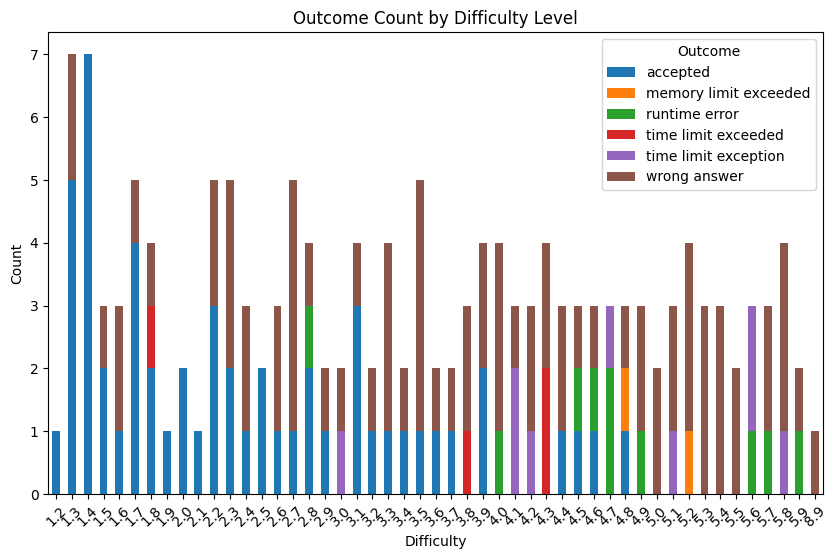

In [6]:
# Creating a stacked bar chart for each result at each difficulty
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Difficulty')
ax.set_ylabel('Count')
ax.set_title('Outcome Count by Difficulty Level')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.show()

# Figure out which feutures to have as inputs in a prediction model, Figure engineering. With what to get from the problem statements. Readability, frequency of words, etc. think of meaningful features. perform unsupervised learning, understanding the features.

In [7]:
# Functions to get all problems
def find_prompt_files(directory):
    prompt_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if 'gpt_prompt' in file:  # Check if 'gpt_prompt' is in the file name
                prompt_files.append(os.path.join(root, file))
    return prompt_files

def get_problem(filepath):
    with open(filepath, 'r') as f:
        problem = f.read().strip()
    return [problem]

kattis_dir = os.path.join(os.getcwd(), 'kattis')
prompt_files = find_prompt_files(kattis_dir)
all_problems = []

for filepath in prompt_files:
    comments = get_problem(filepath)
    all_problems.extend(comments)


In [10]:
all_problems = all_problems[:20]
for problem in all_problems:
        doc = nlp(problem)

        # Extract keywords (nouns and verbs) excluding stopwords
        keywords = [token.text.lower() for token in doc if token.text.lower() not in STOP_WORDS]

        # Count the frequency of each keyword
        keyword_freq = Counter(keywords)

        # Look into another filter for words that are important

        # Print the top keywords and their frequencies
        print(keyword_freq)

Counter({',': 23, '.': 18, 'integers': 6, '2048': 5, '-': 5, 'puzzle': 5, '2': 5, 'tile': 5, 'input': 5, 'grid': 4, 'tiles': 4, 'th': 4, 'integer': 4, 'cell': 4, '0': 4, 'player': 3, '4x4': 3, 'contains': 3, '/': 3, '\n\n': 3, 'line': 3, 'new': 3, 'single': 2, 'game': 2, 'left': 2, 'right': 2, 'merge': 2, 'value': 2, '\n': 2, 'state': 2, 'lines': 2, '16': 2, 'j': 2, 'denotes': 2, 'problem': 2, '4': 2, 'means': 2, 'output': 2, 'created': 1, 'gabriele': 1, 'cirulli1': 1, 'played': 1, ' ': 1, '>': 1, '=': 1, 'powers': 1, 'use': 1, 'keyboard': 1, 'arrow': 1, 'key': 1, '(': 1, ')': 1, 'simultaneously': 1, 'slide': 1, 'far': 1, 'possible': 1, 'chosen': 1, 'direction': 1, 'stopped': 1, 'edge': 1, 'number': 1, 'collide': 1, 'moving': 1, 'total': 1, 'collided': 1, 'resulting': 1, 'observe': 1, 'merging': 1, 'behavior': 1, 'carefully': 1, 'sample': 1, 'inputs': 1, 'outputs': 1, 'valid': 1, 'describe': 1, 'content': 1, 'located': 1, 'row': 1, '{': 1, '8': 1, '32': 1, '64': 1, '128': 1, '256': 1, 

In [8]:
# Do all textstat readability and find best features from them

all_problems = all_problems[:20]

with open("dale-chall_word_list.txt", "r") as file:
    dale_chall_words = set(word.strip().lower() for word in file.readlines())

with open("output.csv", mode="w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Word Count", "Difficult Word Count", "DCR"])

    for problem in all_problems:
        doc = nlp(problem)
        word_count = len([token for token in doc if not token.is_punct])
        difficult_word_count = len([token for token in doc if token.text.lower() not in STOP_WORDS and token.text.lower() not in dale_chall_words])
        sentence_count = len(list(doc.sents))
        avg_sentence_length = word_count / sentence_count
        pdw = (difficult_word_count / word_count) * 100
        dcr = 0.1579 * (pdw + 0.0496 * avg_sentence_length) + 3.6365
        info = word_count, difficult_word_count, dcr
        writer.writerow(info)
        



In [9]:
# Adopt one-hot encoding for y values: wrong, accepted, error
# cross-validation techniques
# grid search: model training
